## Coding assignment : riding the wave

In this assignement, we'll try to model the behavior of a 1-dimensional shockwave in an inviscid compressible gas. The  Sod's shock tube is an idealized tube consisting of an infinitily thin diaphragm separating a high-pressure region on the left of the tube, and a low presure region on the right. When instantly taking off the diaphragm at t=0s, a shockwave travelling to the righ and an expansion wave travelling to the left appears.

This particular setting alows an analytical solution to Euler equations that govern the equation of motion of inviscid fluid. Thus we'll use them, plus the energy equation, to solve our problem. 

The Eulers equations are expressed by combining the conservation laws of mass, momentum and energy for an inviscid fluid with density $\rho$ , speed $u$ and pressure $p$ :
$$
\frac{\partial }{\partial t} \vec{\mathbf{u}} + \frac{\partial }{\partial x} \vec{\mathbf{f}} = 0
$$

With the u vector containing the conserved quantities cited above : 
$$
\vec{\mathbf{u}} = \left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]$$

And the f vector being the flux vector :
$$
\vec{\mathbf{f}} = \left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u \\ \end{array} \right]
$$

The problem here is that we have three equations but four unknown. Let's express the third componenent of the f vector only in term of the density, the velocity and the pressure. Using the equation of state for an ideal gaz, we have :
$$e = e(\rho, p) = \frac{p}{(\gamma -1) \rho},$$

where $\gamma = 1.4$ is a reasonable value to model air.

We can now rewrite the pressure as :
$$p = (\gamma -1)\left(\rho e_T - \frac{\rho u^2}{2}\right).$$

Finally, we need to express $ \vec{\mathbf{f}}= 
\left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right]$ in terms of $\vec{\mathbf{u}} = 
\left[ \begin{array}{c}
u_1 \\
u_2 \\
u_3 \\ 
\end{array} \right]$. After some manuplation, it gives : 
$$\vec{\mathbf{f}} = \left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]$$



### Libraries and initial conditions

* #### Libraries :

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

* #### Initial conditions :

Knowing that the tube is spanning from x=-10m to x=10m with the rigid membrane at x=0m, the initial conditions at t=0s, are on the left : 
$$\vec{IC}_L = \left[ \begin{array}{c}
\rho_L \\ u_L \\ p_L \\ \end{array}\right] = 
\left[ \begin{array}{c}
1\ kg/m^3 \\ 0\ m/s \\ 100000\ N/m^2 \\ \end{array}\right]$$

And on the right (containing x=0m) :
$$\vec{IC}_R = \left[ \begin{array}{c}
\rho_R \\ u_R \\ p_R \\ \end{array}\right] = 
\left[ \begin{array}{c}
0.125\ kg/m^3 \\ 0\ m/s \\ 10000\ N/m^2 \\ \end{array}\right]$$

Wich in python, gives :



In [2]:
" These can be changed if you need to se he results with different initial conditions "

nx=81
tfinal=0.01   # In our case we are looking for the results at t=0.01 s
dx=0.25       # Space step in meter
dt=0.0002     # Time step in seconds
gamma=1.4
nt=int(tfinal/dt)

ICL = numpy.array([1,0,100000])     # Initial conditions for x in [-10,0[ : ICL = [rhoL,vL,pL]
ICR = numpy.array([0.125,0,10000])  # Initial conditions for x in [0,10] : ICR = [rhoR,vR,pR]

In [3]:
u_0 = numpy.ones((nx,3))

For the left side of the tube

In [4]:
#Expressing the initial conditions
u_0[:int((nx-1)/2), 0] = ICL[0]
u_0[:int((nx-1)/2), 1] = ICL[0]*ICL[1]
u_0[:int((nx-1)/2), 2] = ICL[0]*(ICL[2]/((gamma-1)*ICL[0])+(ICL[1]**2)/2) 

For the right side of the tube (including x=0)

In [5]:
u_0[int((nx-1)/2):, 0] = ICR[0]
u_0[int((nx-1)/2):, 1] = ICR[0]*ICR[1]
u_0[int((nx-1)/2):, 2] = ICR[0]*(ICR[2]/((gamma-1)*ICR[0])+(ICR[1]**2)/2) 

In [6]:
print(u_0[40])  # 40*dx=40*0,25=10m, we're at the middle of the tube, in x=0m

[  1.25000000e-01   0.00000000e+00   2.50000000e+04]


### Functions

* Vector u :

*It was already defined in its initial state, we won't need to define it as a function.*

* Flux F :

In [7]:
def f(u,gamma) :
    
    F = numpy.empty_like(u)
     
    F[:,0] = u[:,1]
    F[:,1] = (u[:,1]**2)/ u[:,0] + (gamma-1)*(u[:,2] -(u[:,1]**2)/(2*u[:,0]))
    F[:,2] = u[:,1]/u[:,0] * (u[:,2] + (gamma-1)*(u[:,2] - (u[:,1]**2)/(2*u[:,0])))
    
    return F


### Solving the equations : the Richmeyer method

To solve these equations, we will use the Richmeyer's method. It's a two step method, consisting of two discrete equations : 

The "predictor" :
$$
\vec{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \frac{1}{2} \left( \vec{\mathbf{u}}^n_{i+1} + \vec{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \vec{\mathbf{f}}^n_{i+1} - \vec{\mathbf{f}}^n_i\right) $$ 

And the "corrector" : 
$$
\vec{\mathbf{u}}^{n+1}_i = \vec{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\vec{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \vec{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
$$

Where, in the second step, 
$$\vec{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \vec{\mathbf{f}}\left(\vec{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}}\right).$$

In [8]:
def Richtmyer_solver(u_0,nt,nx,dt,dx,gamma,f):
    
    u = u_0.copy()
    uh = u_0.copy() # for u(i+1/2,n+1/2)
    un = u_0.copy()
 
  
    for i in range (0,nt):
       
        f_func=f(u,gamma)
        
        uh[:-1,:] = 0.5*(u[1:,:]+u[:-1,:])-dt/(2*dx)*(f_func[1:,:]-f_func[:-1,:])  # Predictor

        fh_func=f(uh,gamma)
        
        un[1:-1,:]=u[1:-1,:]-dt/dx*(fh_func[1:-1,:]-fh_func[:-2,:])   #Corrector
        
        u=un
        
    
        
    return u

* #### Solution

We want to calculate the Density, velocity and pressure, at t=0,01s and x=2,5m :

In [9]:
U=numpy.empty((nx,3))
U=Richtmyer_solver(u_0,nt,nx,dt,dx,gamma,f)

rho=U[50,0]
vel=U[50,1]/U[50,0]
p=(U[50,2] - 0.5*U[50,0]*(U[50,1]/U[50,0])**2)*(gamma - 1)     # Considering the fact that U[40,:] is at x=0m,  
                                                               # x=2,5m is at 10 step away, thus U[50,:]
print("At t = 0.01 and x = 2.5 :")
print("Density =", rho, "    Velocity =", vel, "    Pressure =",p)

At t = 0.01 and x = 2.5 :
Density = 0.374691402648     Velocity = 292.611471527     Pressure = 30250.8901676


* #### Graphics for rho, u and p at t=0,01s


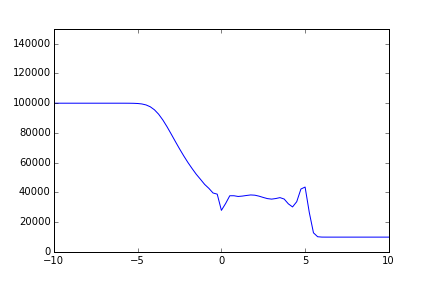
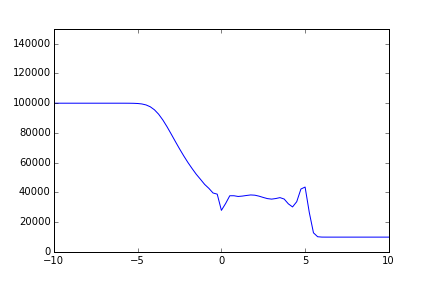
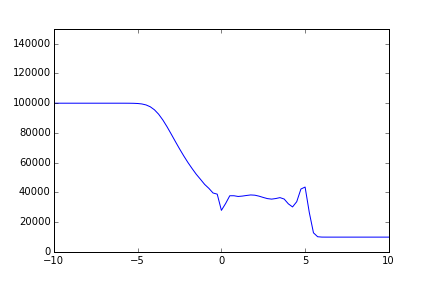
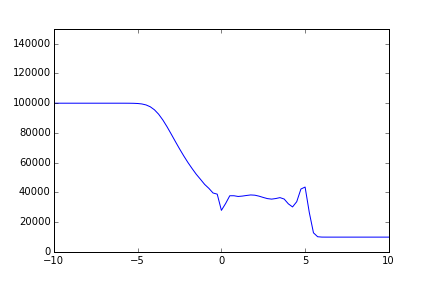
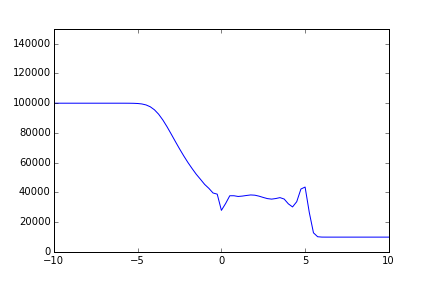
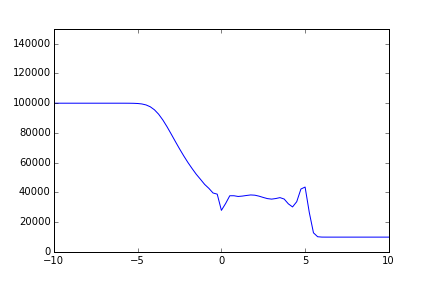
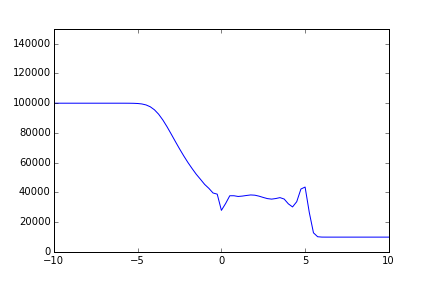
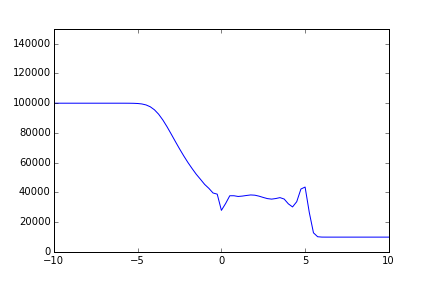
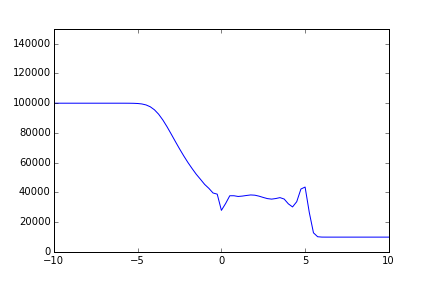
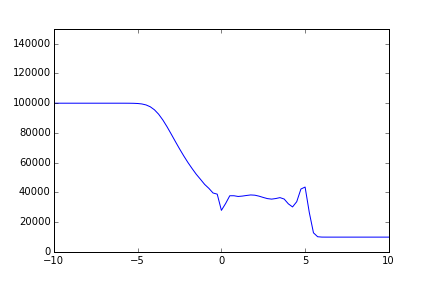
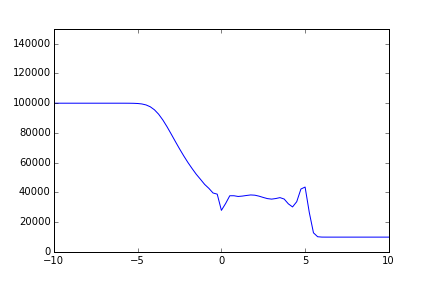
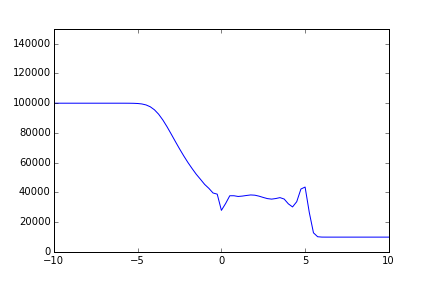
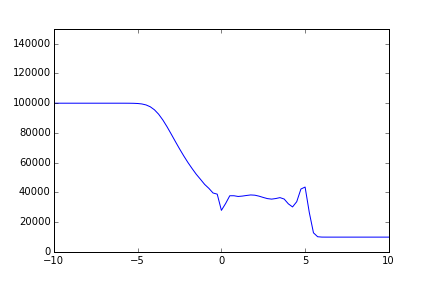
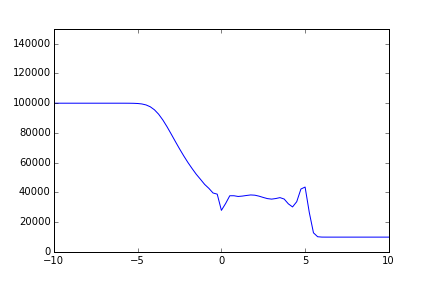
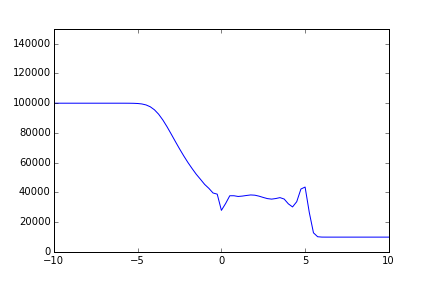
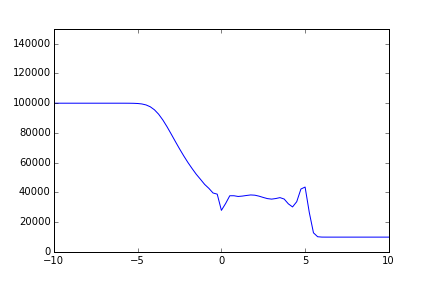
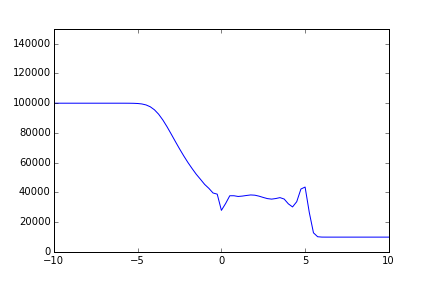
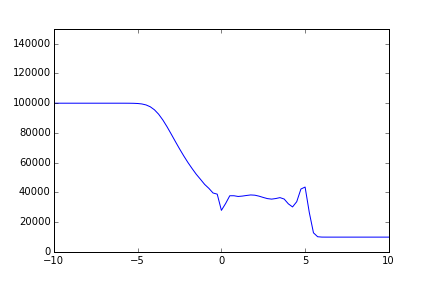
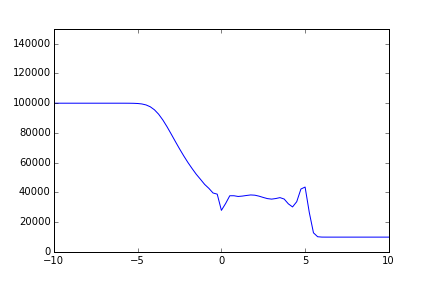
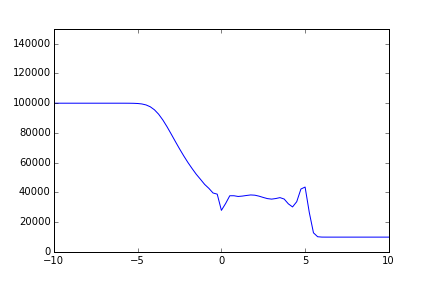
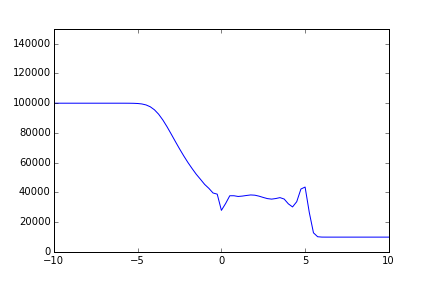
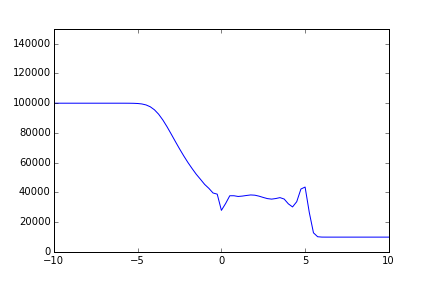
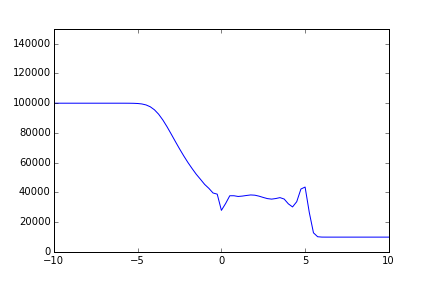
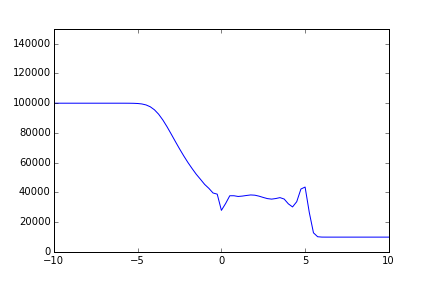
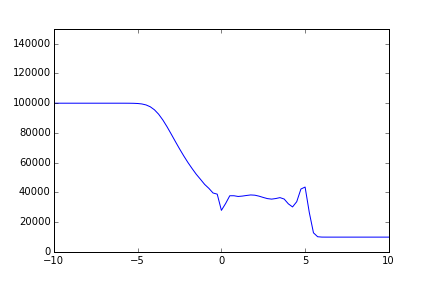
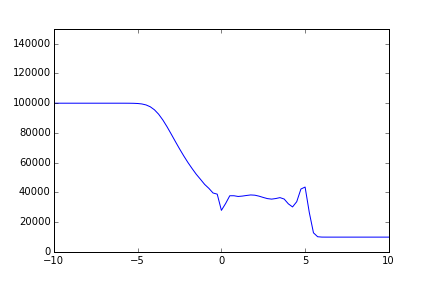
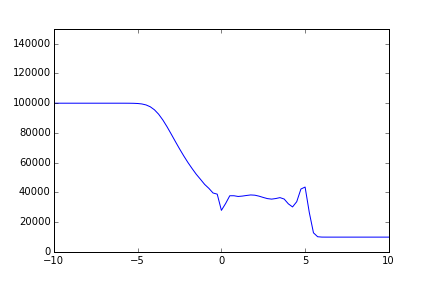
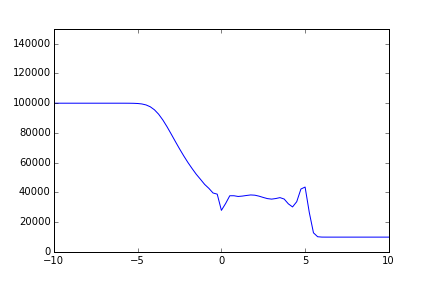
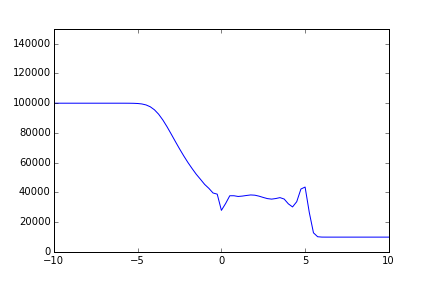
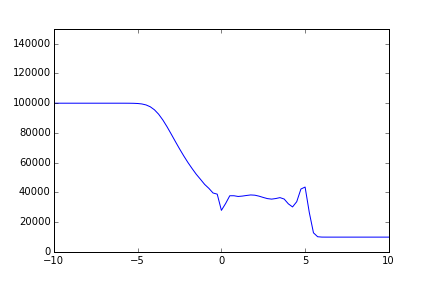
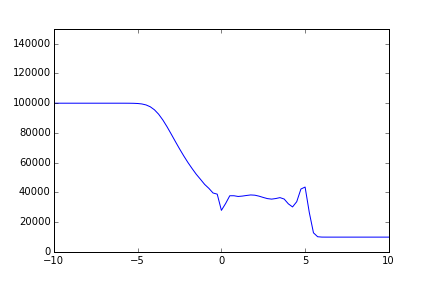
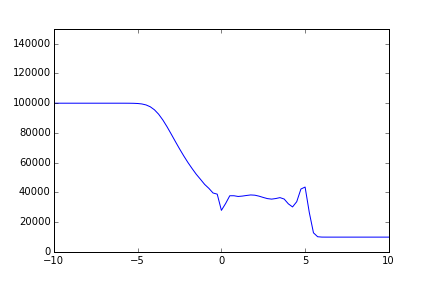
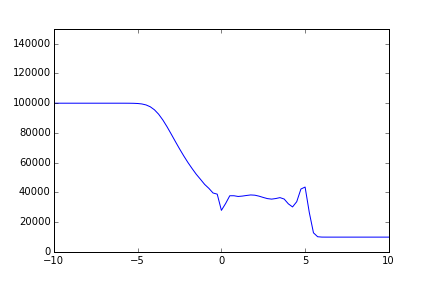
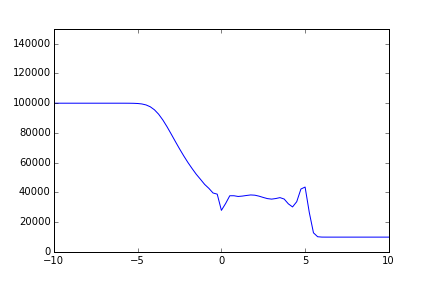
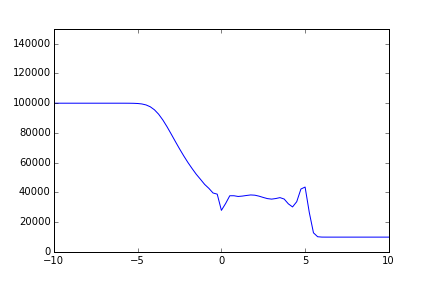
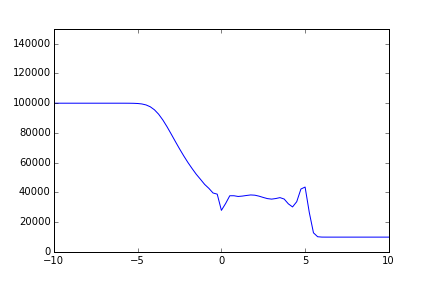
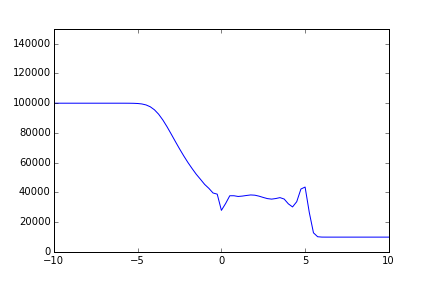
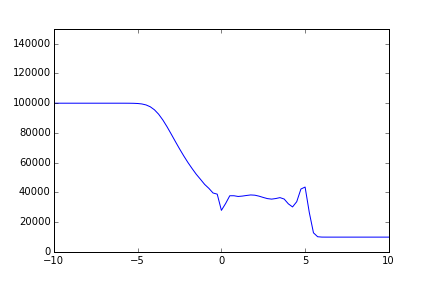
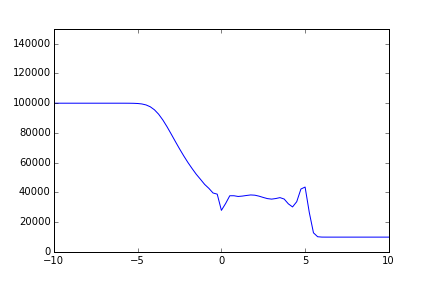
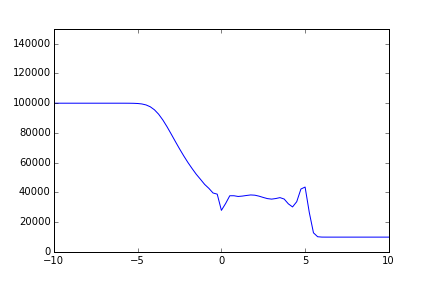
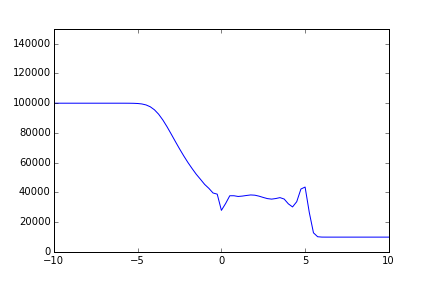
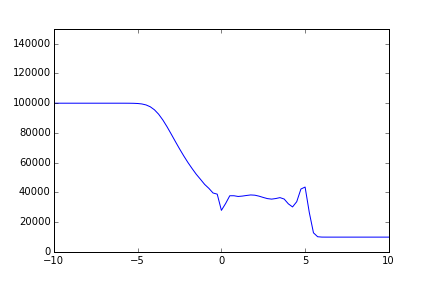
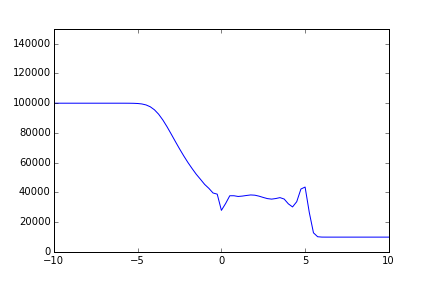
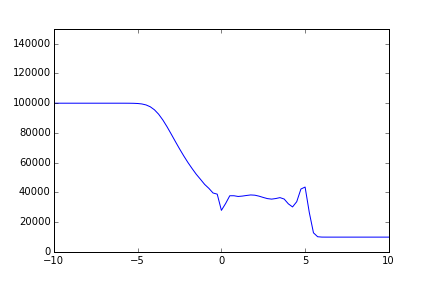
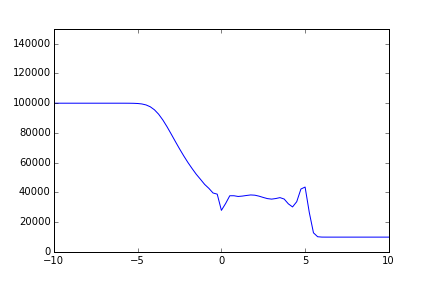
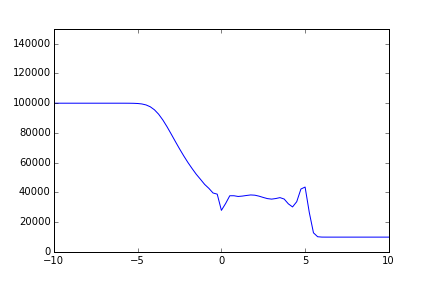
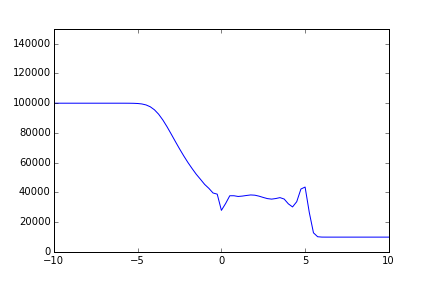
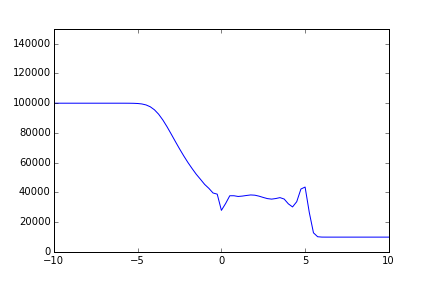
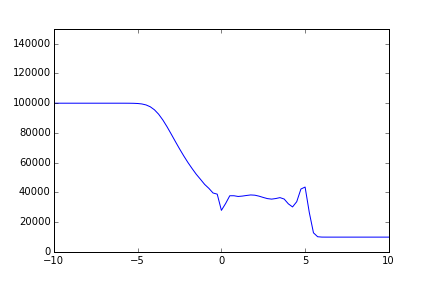
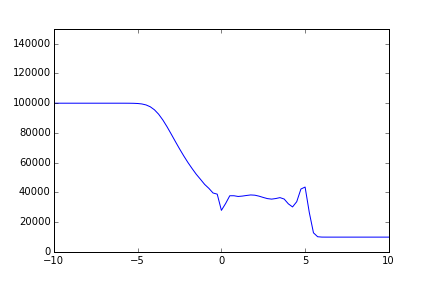

In [10]:
xmin = -10
xmax = 10
x = numpy.linspace(xmin, xmax, nx)
nt=int(0.01/dt)+1 

#Graphic for the pressure at t=0,01s : p=f(x)
fig1 = pyplot.figure()
line1, = pyplot.plot([],[]) 
pyplot.xlim(xmin, xmax)
pyplot.ylim(0,150000)

def animate1(nt):
    line1.set_data(x,0.4*(U[:,2]-U[:,0]*U[:,1]/2))
    return line1,
 
animation.FuncAnimation(fig1, animate1, frames=50, blit=True, interval=50, repeat=False)



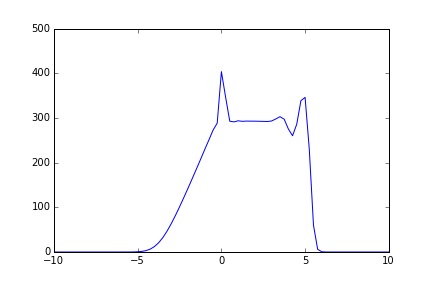
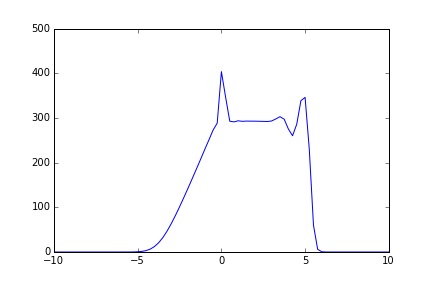
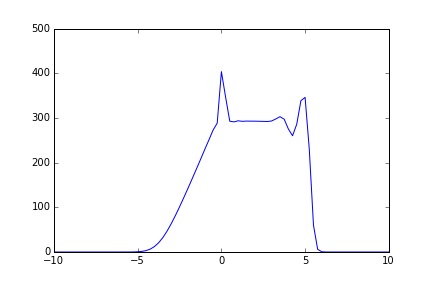
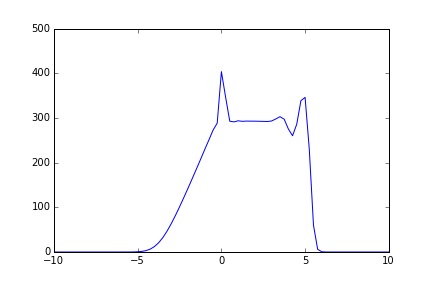
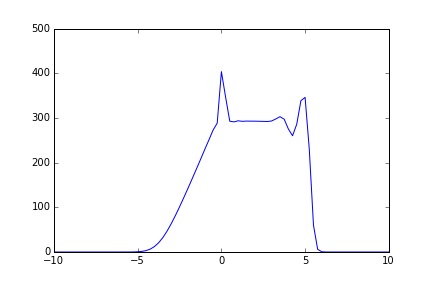
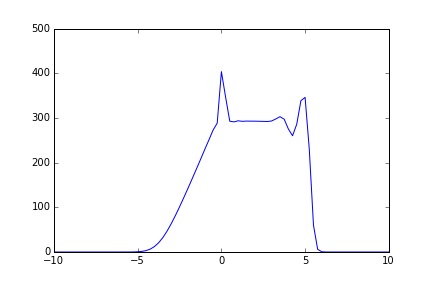
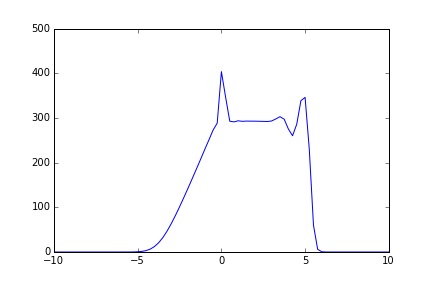
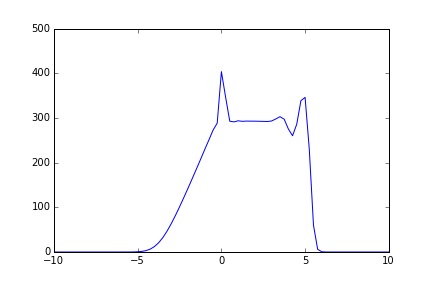
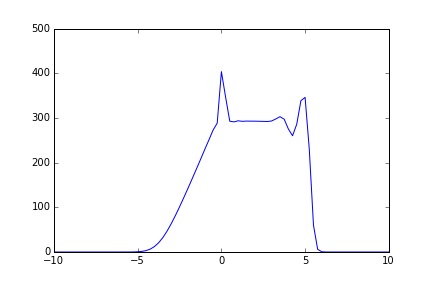
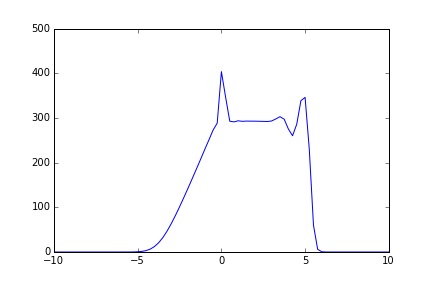
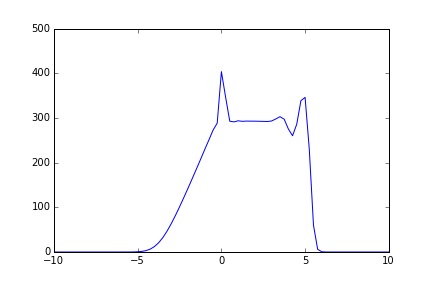
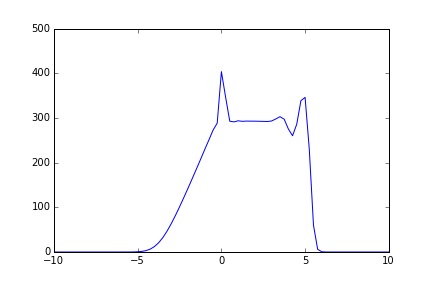
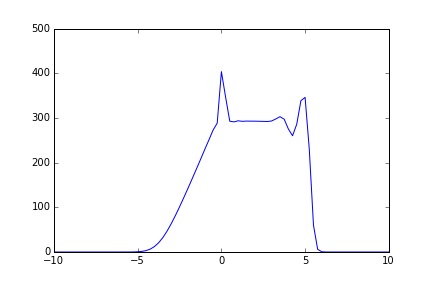
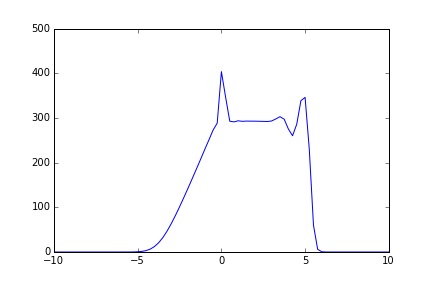
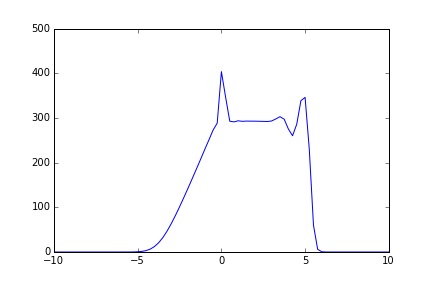
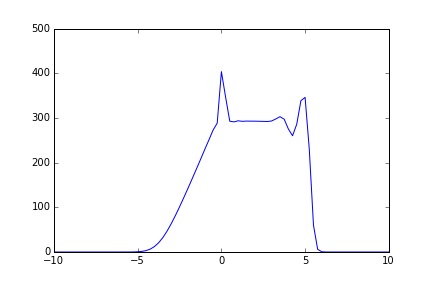
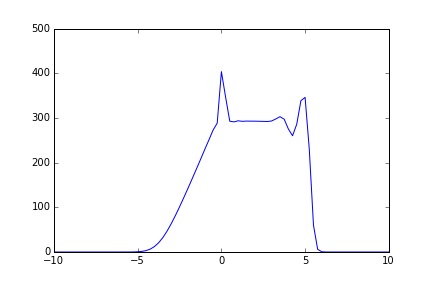
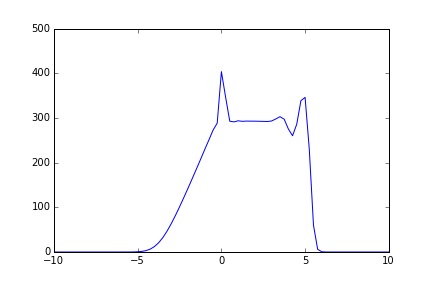
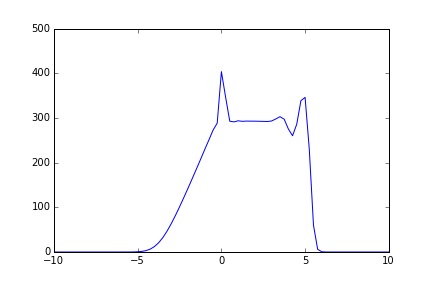
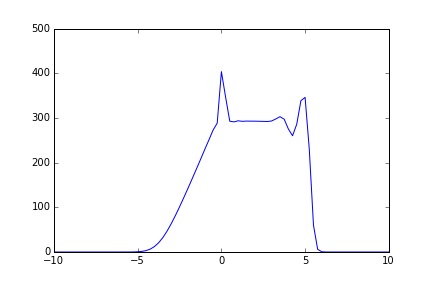
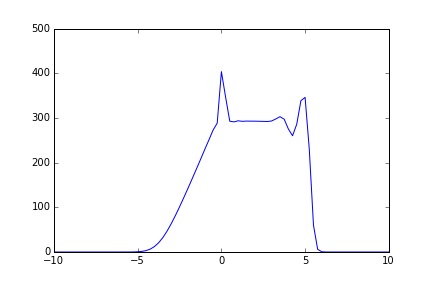
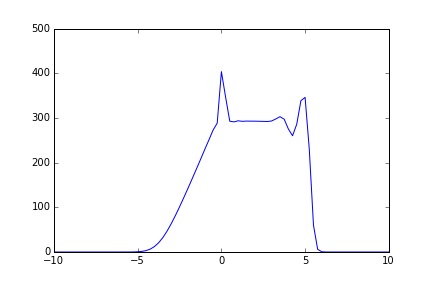
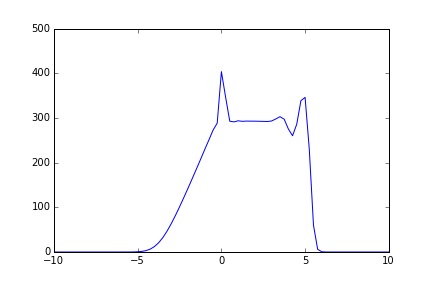
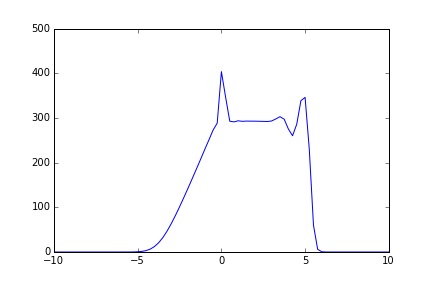
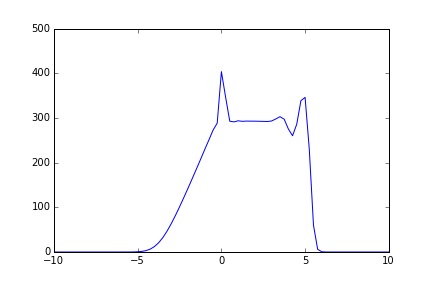
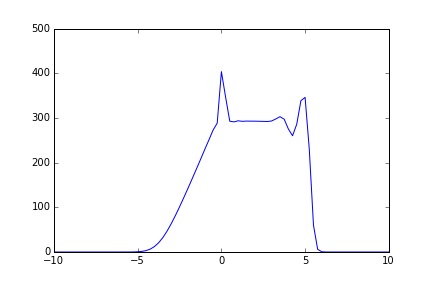
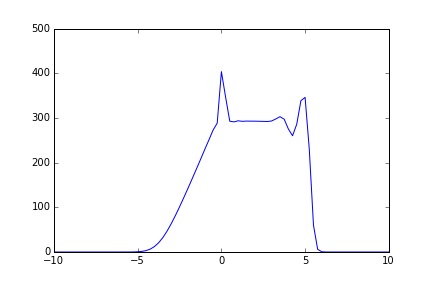
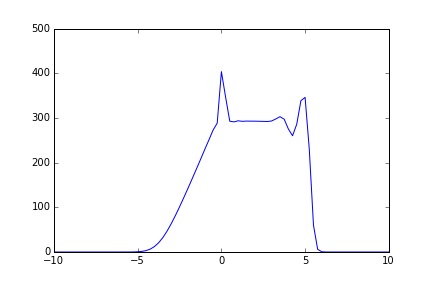
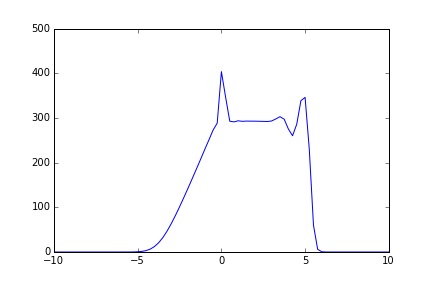
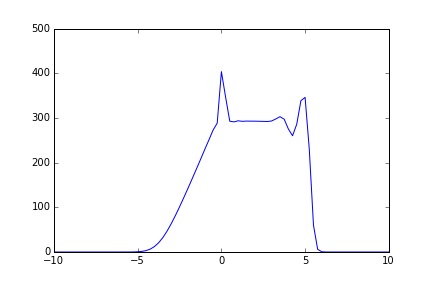
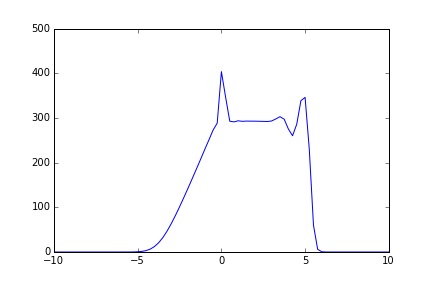
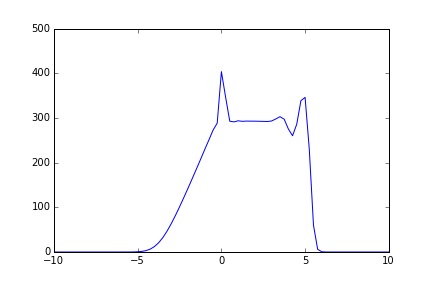
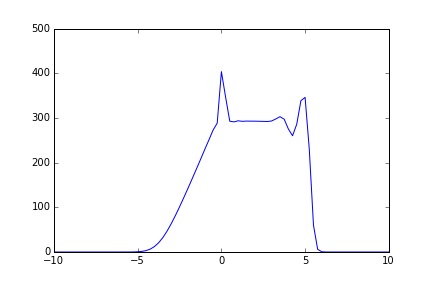
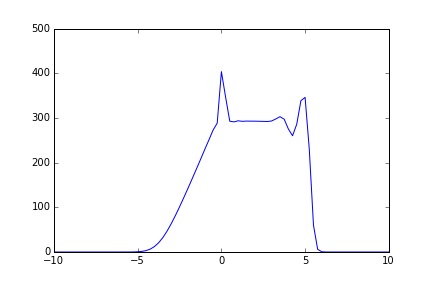
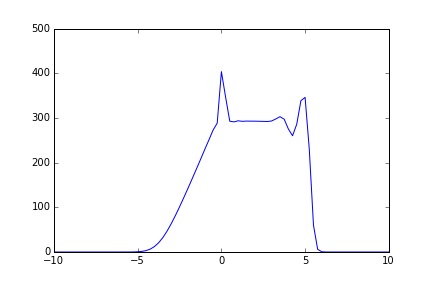
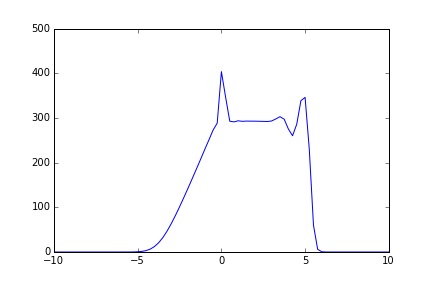
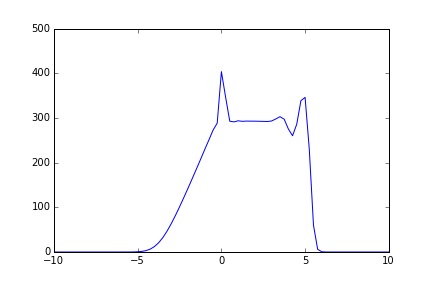
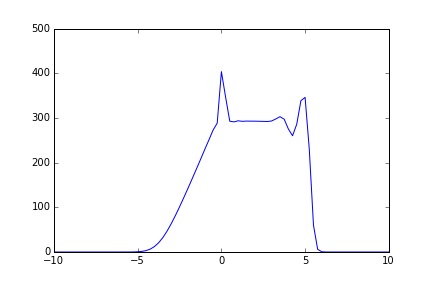
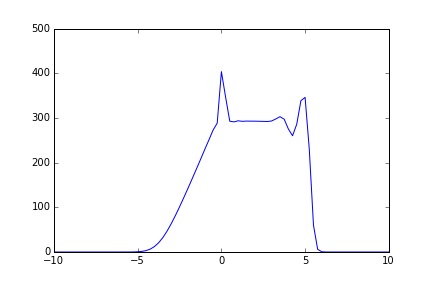
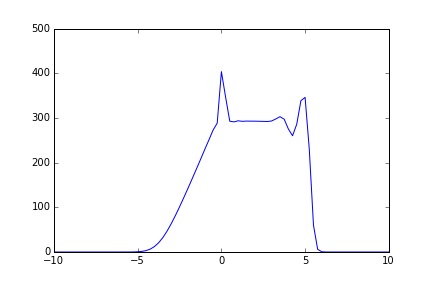
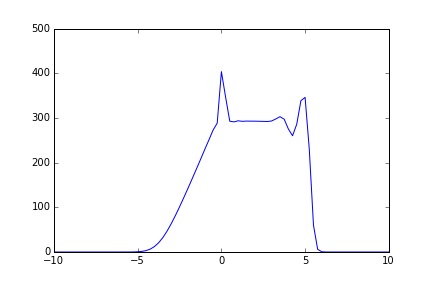
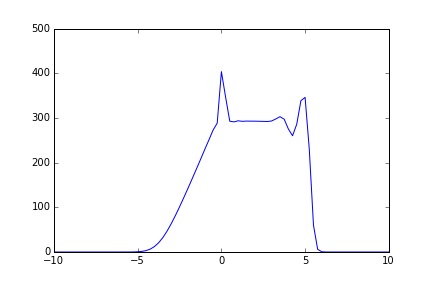
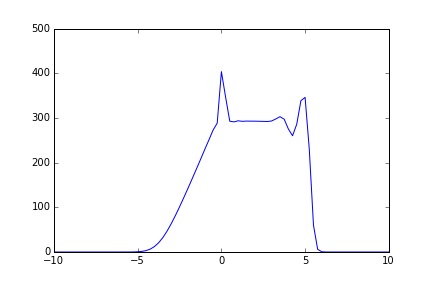
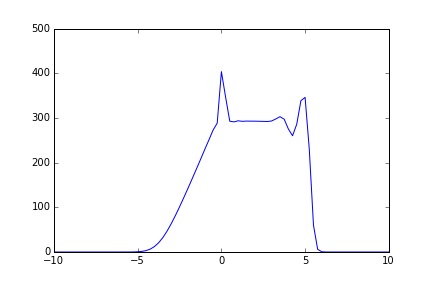
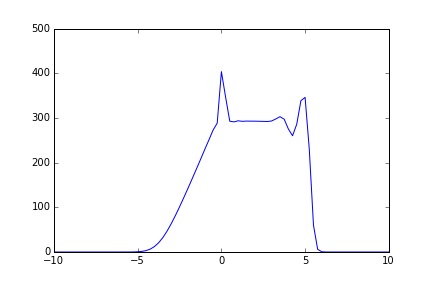
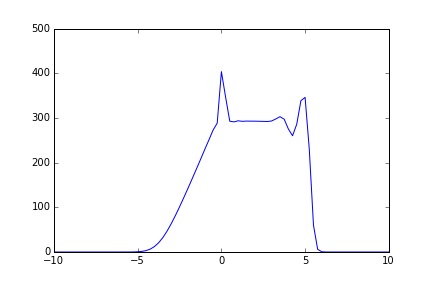
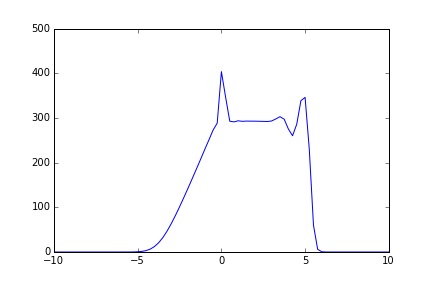
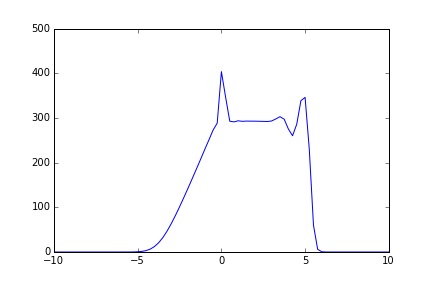
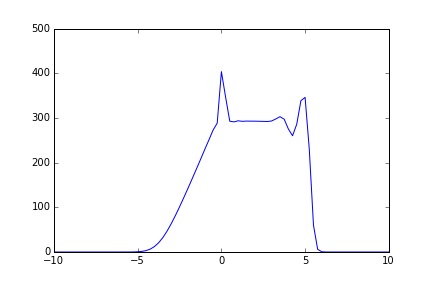
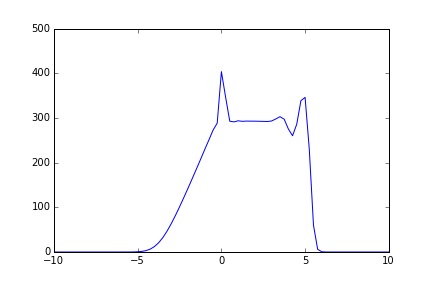

In [11]:
# Graphic for the velocity at t=0,01s : u=f(x)

fig3 = pyplot.figure()
line3, = pyplot.plot([],[]) 
pyplot.xlim(xmin, xmax)
pyplot.ylim(0,500)

def animate3(i): 
    line3.set_data(x,U[:,1]/U[:,0])
    return line3,
 
animation.FuncAnimation(fig3, animate3, frames=50, blit=True, interval=50, repeat=False)


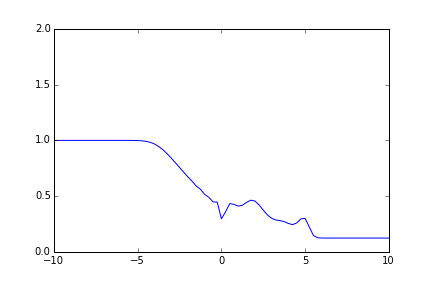
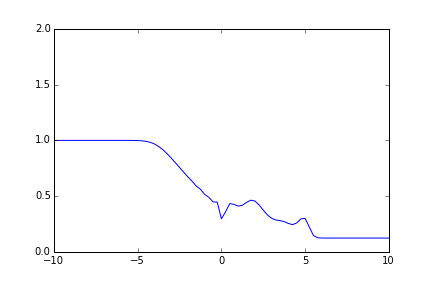
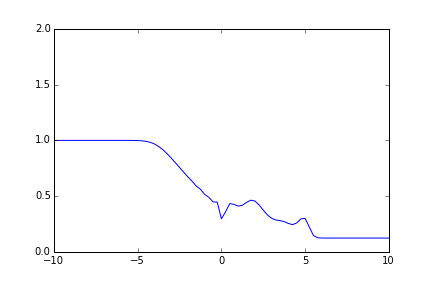
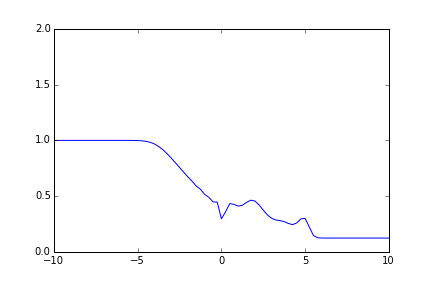
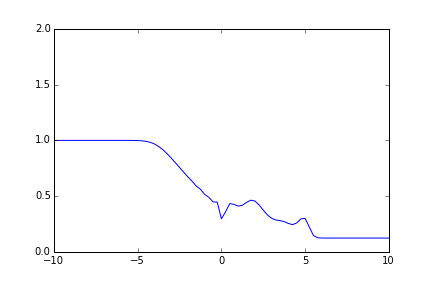
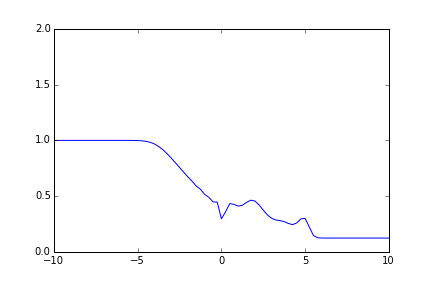
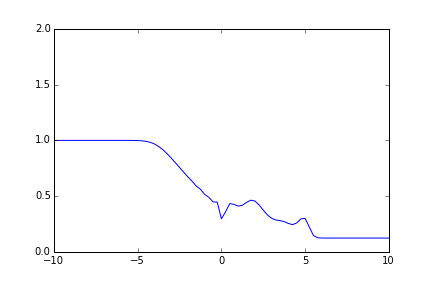
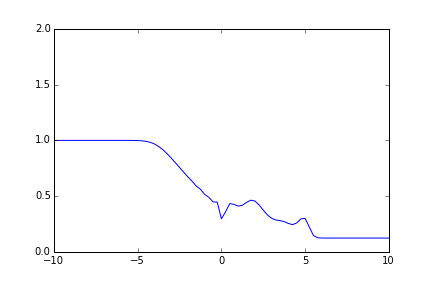
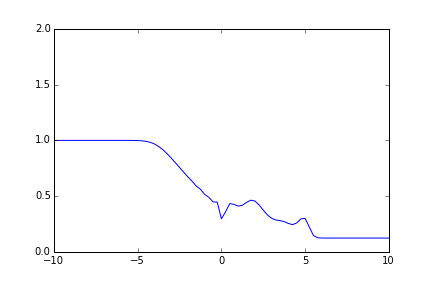
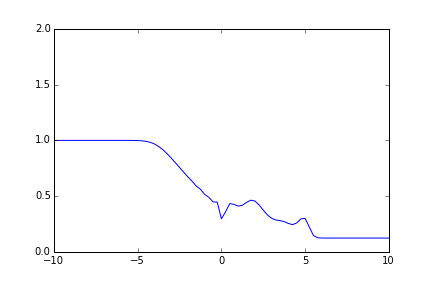
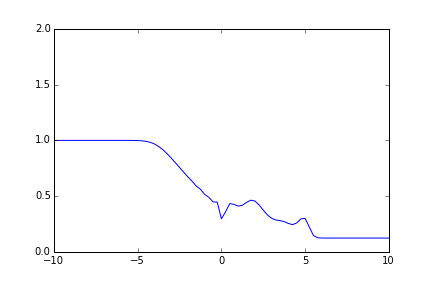
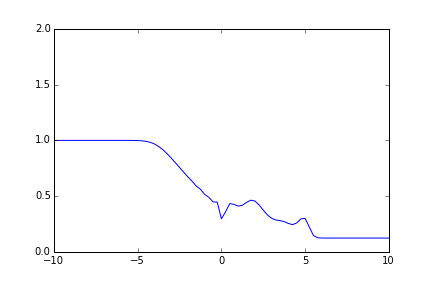
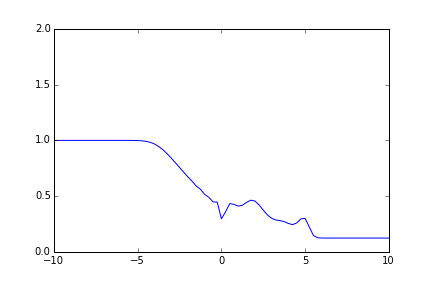
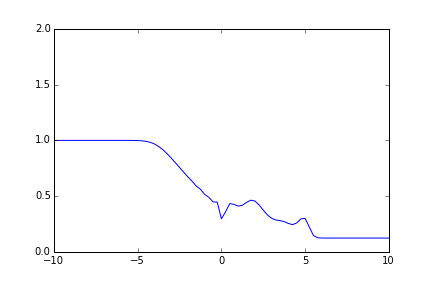
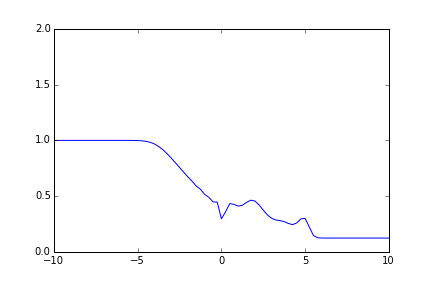
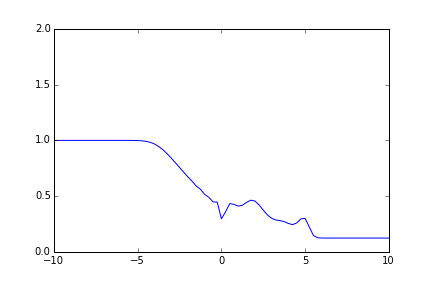
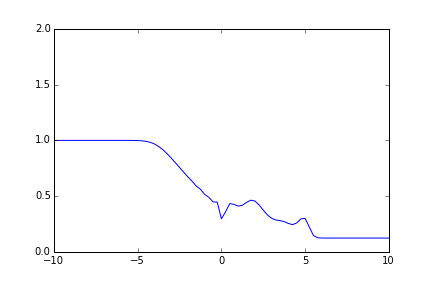
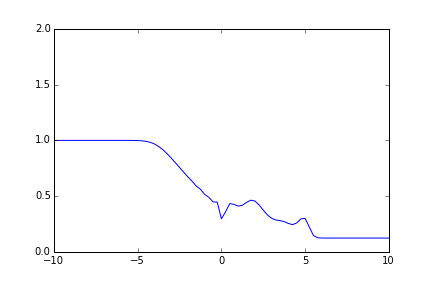
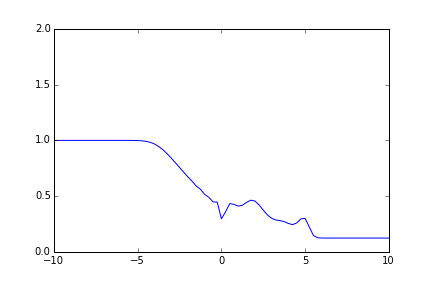
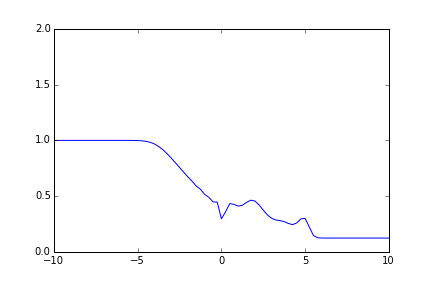
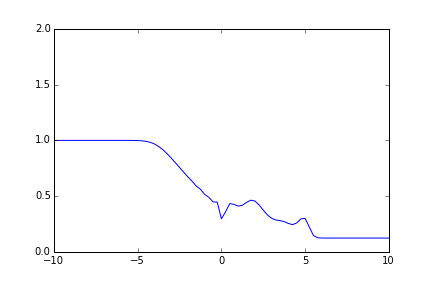
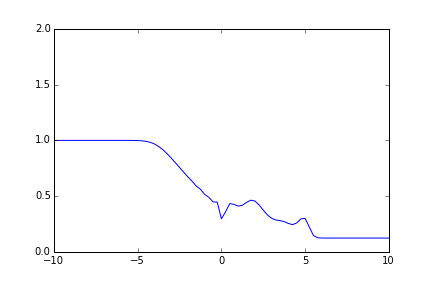
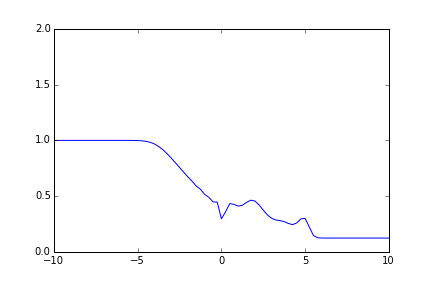
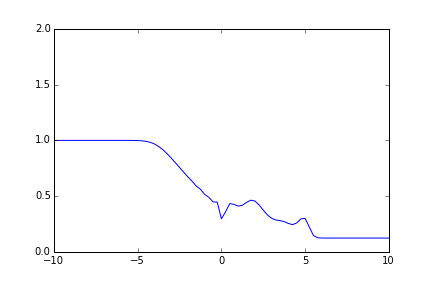
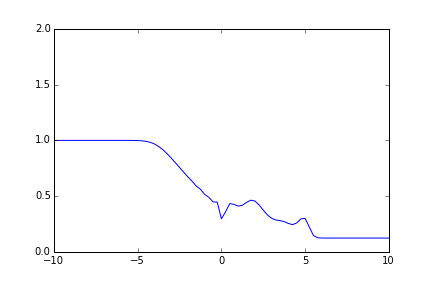
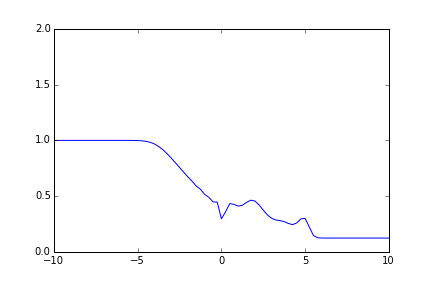
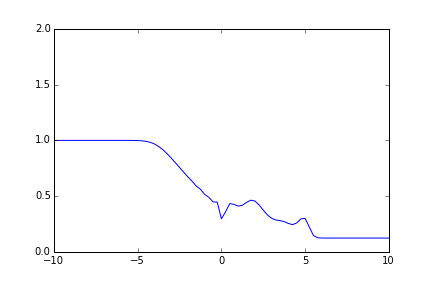
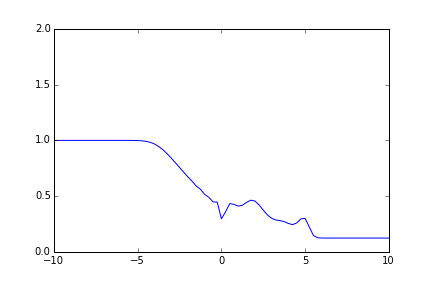
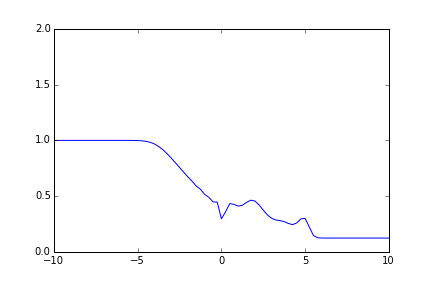
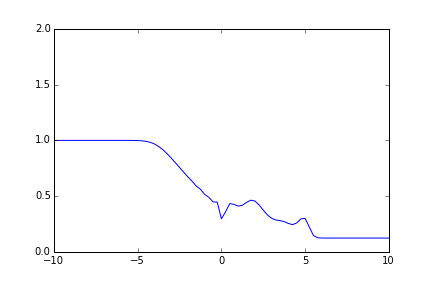
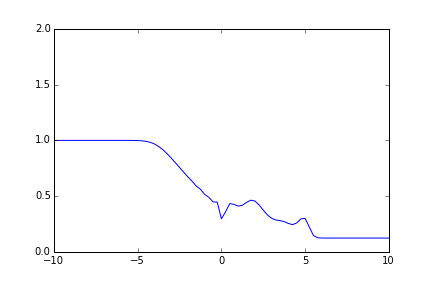
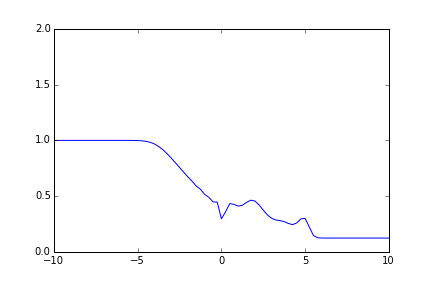
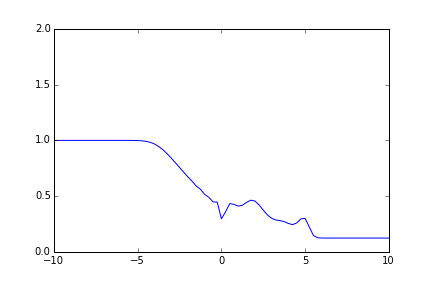
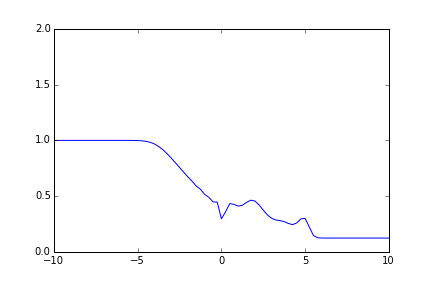
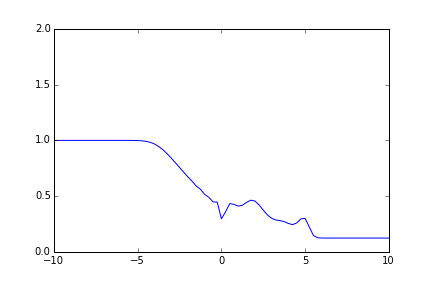
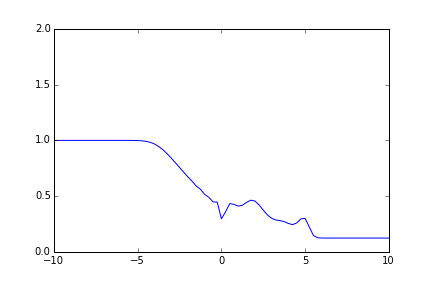
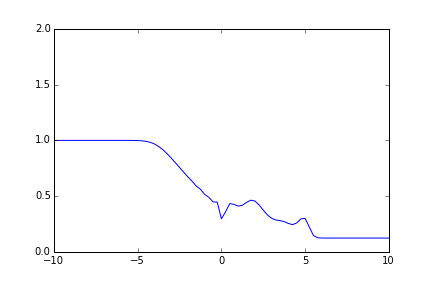
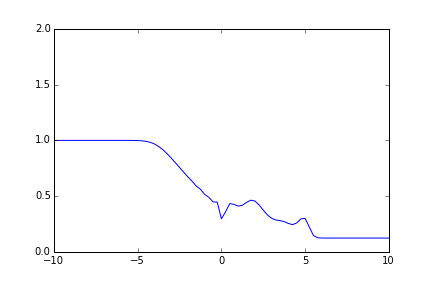
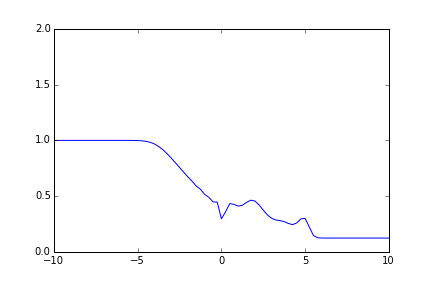
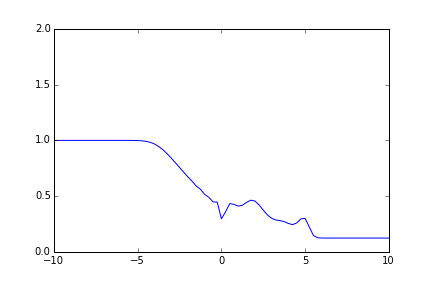
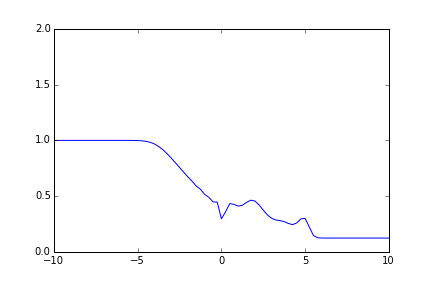
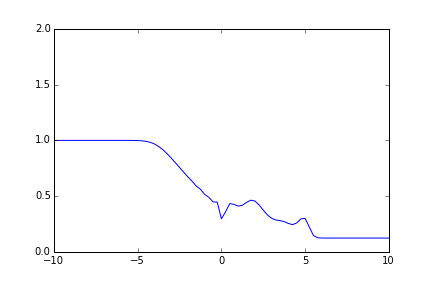
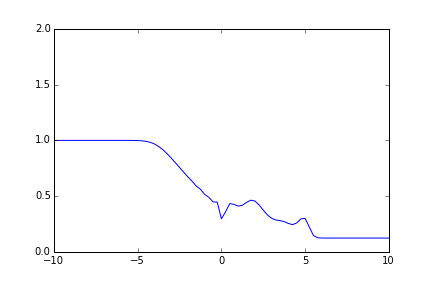
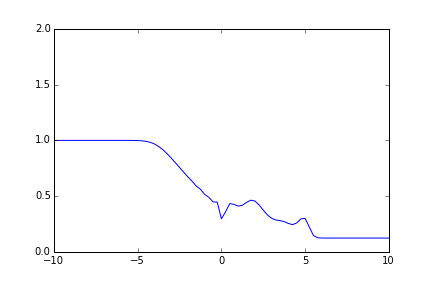
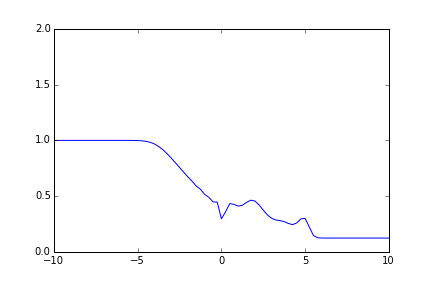
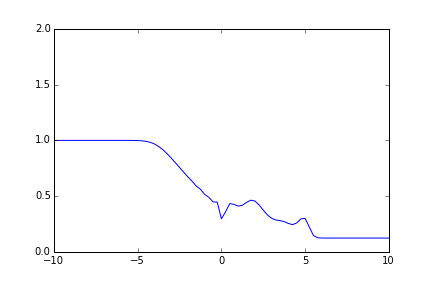
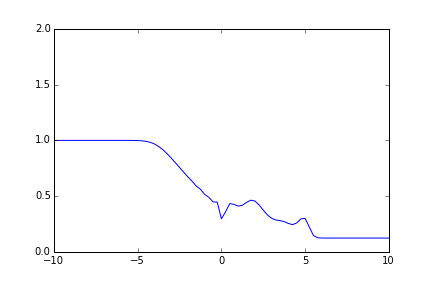
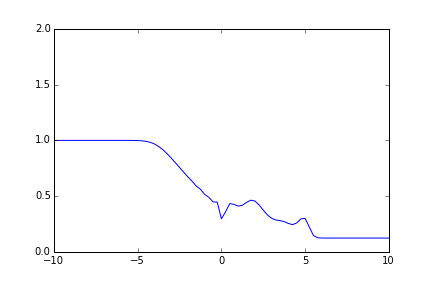
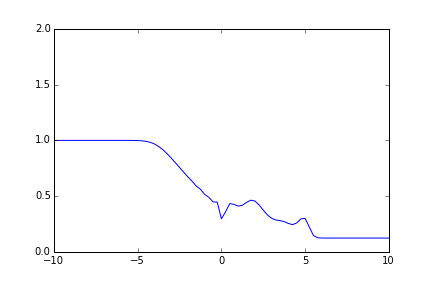
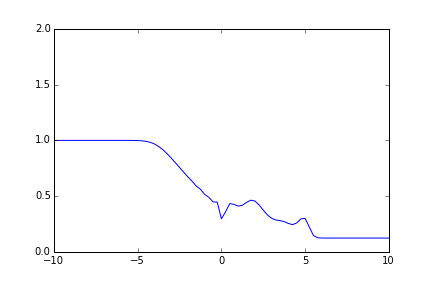

In [12]:
# Graphic for the density at t=0,01s : rho=f(x)
fig2 = pyplot.figure()
line2, = pyplot.plot([],[]) 
pyplot.xlim(xmin, xmax)
pyplot.ylim(0,2)

def animate2(i): 
    line2.set_data(x,U[:,0])
    return line2,
 
animation.FuncAnimation(fig2, animate2, frames=50, blit=True, interval=50, repeat=False)




### Conclusions

First of all, we would like to precise something. After finishing our code, we wanted to display animated graphics for the pressure, the density and the velocity, but we realised that in order to do it, we should have dealt with the Richmeyer method using a 3 indices function (the third being the time indice), instead of our u_0 containing two indices. Because of this, we couldn't dsiplay our values at any time without changing the value of nt. As it was too late to change all the code, we decided instead to display graphics of the pressure, the density and the velocity at the time of interest in this problem, t=0,01s, we're sorry for that.

Nevertheless, we managed to see the animated graphics of our friends (wich would have been the same as ours, as we have the right values of p,u and rho). 

We can see that the Richmeyer method works well for describing the physic of this experiment, except for the behavior at the edge of the shockwave. Indeed, we can see that some unexpected perturbation are present.
Anyway, in the animated graphics, we can clearly see the shockwave : the high pressure/high density gas flowing to the low pressue/low density gas (on the right side of the tube). We can also have glimpse of the expansion wave on the left side of the tube.

Hope you enjoyed the ride !



